# Dummy Regressor Evaluation

In this notebook, we evaluate the **Dummy Regressor** baseline model for drug sensitivity prediction. The Dummy Regressor predicts the **mean** of the target variable (IC50) for all data points. We use **5-fold cross-validation** to evaluate stability across splits.


We will evaluate the performance using:
1. **RMSE (Root Mean Squared Error)**
2. **R² (Coefficient of Determination)**

We will also visualize:
- **RMSE** and **R²** vs Drug ID
- **Residuals** (actual - predicted)
- **Predicted vs Actual IC50**


In [1]:
import os
import polars as pl
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define a constant for the number of PCs
NUM_PCS = 30

# Load final dataset
final_data = pl.read_parquet("../../../data/processed/bulk_with_pca.parquet")
print("✅ Dataset loaded:", final_data.shape)

# create directory for results
os.makedirs("results", exist_ok=True)

✅ Dataset loaded: (571985, 33)


## 1. Compute Metrics per Drug

We evaluate the Dummy Regressor for each drug independently:
- For each drug, we extract the subset of cell lines exposed to it.
- Train the Dummy Regressor on a train/test split.
- Record RMSE and R² across all drugs.

We only include drugs with **≥ 10 samples** to ensure reliability.


In [4]:
# Use PCA columns (you can switch for HVGs if needed)
pca_columns = [col for col in final_data.columns if col.startswith("PC")]

# Scoring
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for drug_id in sorted(final_data["DRUG_ID"].unique()):
    df = final_data.filter(pl.col("DRUG_ID") == drug_id).drop_nulls("LN_IC50")
    if df.shape[0] < 10:
        continue

    df = df.to_pandas()
    X = df[pca_columns].values
    y = df["LN_IC50"].values

    model = DummyRegressor(strategy="mean")

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    results.append({
        "DRUG_ID": drug_id,
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

# Save results
results_df = pd.DataFrame(results)

# save results to CSV for the specified number of PCs
results_df.to_csv(f"results/dummy_regressor/dummy_regressor_results_{NUM_PCS}_pcs.csv", index=False)
print("📁 Saved to results/dummy_regressor_results_cv.csv")
results_df.head()

📁 Saved to results/dummy_regressor_results_cv.csv


,DRUG_ID,rmse_mean,rmse_std,r2_mean,r2_std
0,1,1.108986,0.171402,-0.036364,0.032988
1,3,2.003308,0.114150,-0.008861,0.012807
2,5,1.650569,0.192533,-0.034595,0.036549
3,6,0.887511,0.126332,-0.020691,0.029201
4,9,1.462640,0.060871,-0.002795,0.002771


## 2. RMSE Distribution

We now visualize the distribution of **RMSE** values across all drugs. This helps us understand:
- How well the Dummy Regressor performs in general
- Whether prediction errors vary a lot between drugs


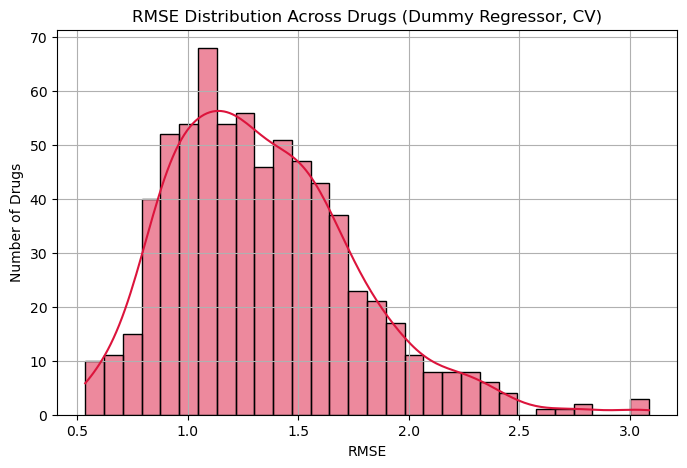

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="crimson")
plt.title("RMSE Distribution Across Drugs (Dummy Regressor, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/dummy_regressor/dummy_regressor_rmse_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

## 3. R² Distribution

We now plot the distribution of **R²** scores across all drugs.

- An **R² close to 0** means the model performs no better than predicting the mean.
- **Negative R²** indicates the model performs worse than the mean.
- Since Dummy Regressor is a constant predictor, R² values will be mostly **≤ 0**.


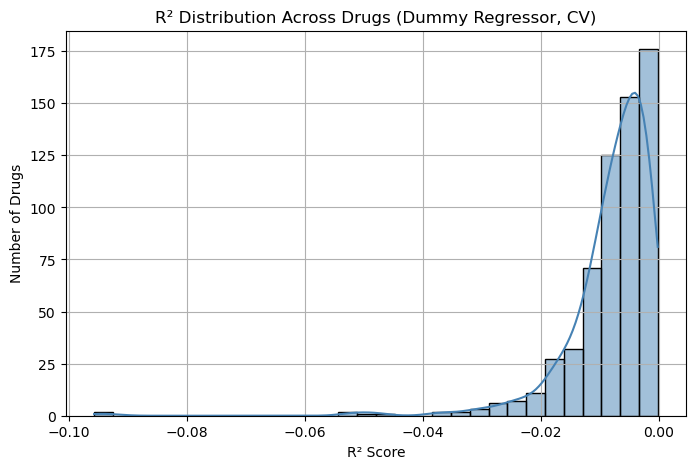

: 

: 

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="steelblue")
plt.title("R² Distribution Across Drugs (Dummy Regressor, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/dummy_regressor/dummy_regressor_r2_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

## 4. Summary

- The Dummy Regressor provides a **baseline** level of performance.
- Most drugs have an **R² ≤ 0**, as expected — this model doesn't learn anything, just predicts the mean.
- The **RMSE distribution** gives us a reference error range for evaluating better models.

👉 Use these plots to compare against Ridge, ElasticNet, and XGBoost results.
